In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DIRECTORY = '/content/drive/My Drive/Informatics/Sphere@mail.ru/1_ML/Lec_7/'

<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика 1

Загрузите данные [отсюда](https://cloud.mail.ru/public/8nHV/p6J7wY1y1) и положите в папку  `data` в директорию с ноутбуком.

In [ ]:
df_churn = pd.read_csv(DIRECTORY + 'data/churn.csv')

In [ ]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    # Удалили признаки
    df_preproc = df_preproc.drop(['State', 'Area Code', 'Phone'], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']] = \
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']].replace({'no': 0, 'yes': 1})
    
    df_preproc.loc[:,  'Churn?'] = df_preproc.loc[:,  'Churn?'].replace({'False.': 0,
                                                                         'True.': 1})
    return df_preproc

In [ ]:
df_preproc = df_churn.pipe(preproc)

In [ ]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values

## Кросс-валидация по одному гиперпараметру

Посмотрим, что делает функция `validation_curve`.

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

`validation_curve` позволяе исследовать влияние отдельного гиперпараметра модели на ее качество.

Построим валидационные кривые по гиперпараметру глубина дерева (`max_depth`) остальных гиперпараметрах, зафиксированных на значениях по-умолчанию

In [ ]:
model = DecisionTreeClassifier(random_state=123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

depths = range(1, 10)
tree_train_scores, tree_valid_scores = validation_curve(model, X, y, 
                                              'max_depth', depths,
                                              cv=cv, scoring='roc_auc')
# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку

In [ ]:
tree_train_scores.shape

(9, 5)

In [ ]:
tree_valid_scores.shape

(9, 5)

Посмотрите, что изображает синяя и красная линия

Text(0, 0.5, 'ROC AUC')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


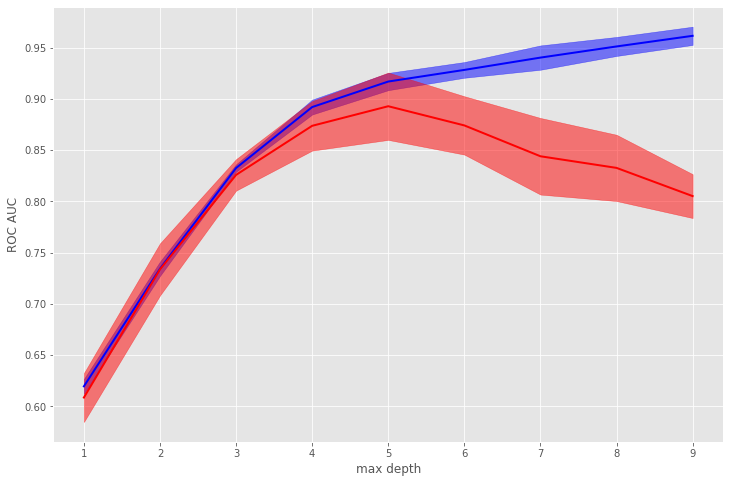

In [ ]:
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(depths, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(depths, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(depths, train_score_mean, c='b', lw=2)
plt.plot(depths, valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

### Важность признаков

Возьмем лучшую модель и выведем важность признаков

In [ ]:
model = ...
imp = model.feature_importances_

Каждое число соответствует важности признака, который подавался на вход

Для каждого признака (с названием) получите его значение важности

In [ ]:
## Your code here

## Бэггинг над деревьями

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                          n_estimators=50, random_state=123)

In [ ]:
_, bag_valid_scores = validation_curve(model, X, y, 
                                      param_name='base_estimator__max_depth', 
                                      param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

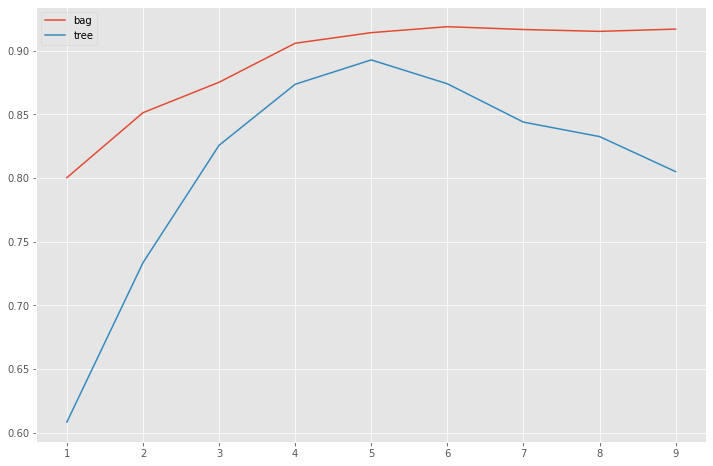

In [ ]:
plt.plot(depths, bag_valid_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_valid_scores.mean(axis=1), label='tree')
plt.legend()

## Случайных лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=123, n_estimators=50, 
                               n_jobs=-1)

In [ ]:
_, forest_valid_scores = validation_curve(model, X, y, 
                                         param_name='max_depth', 
                                         param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=1)

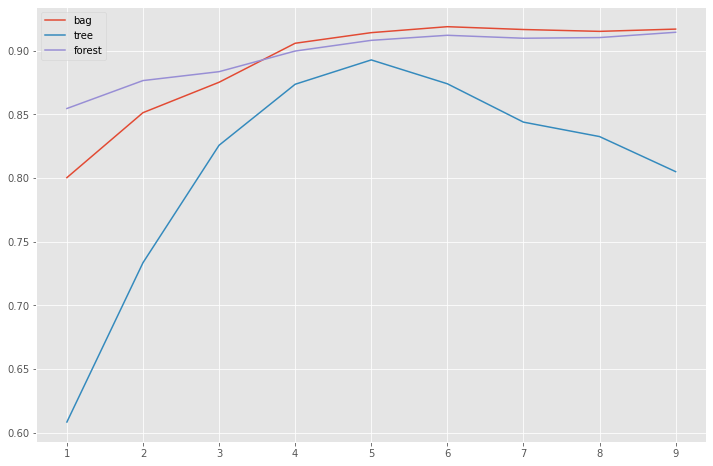

In [ ]:
plt.plot(depths, bag_valid_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_valid_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_valid_scores.mean(axis=1), label='forest')
plt.legend()

## Подбор всех гиперпараметров

Обычно подбирают гиперпараметры целыми группами. Есть несколько способов это делать
* Полный перебор (Grid Search) - явно задаются все возможные значения параметров. Далее перебираются все возможные комбинации этих параметров
* Случайный перебор (Random Search) - для некоотрых параметров задается распределение через функцию распределения. Задается количество случайных комбинаций, которых требуется перебрать.
* "Умный" перебор ([hyperopt](http://hyperopt.github.io/hyperopt/)) - после каждого шага, следующия комбинация выбирается специальным образом, чтобы с одной стороны проверить неисследованные области, а с другой минимизировать функцию потерь. Не всегда работат так хорошо, как звучит.

Мы же попробует случайный поиск. Почему случайный поиск лучше перебора:

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [ ]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 123

In [ ]:
# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_leaf': randint(5, 10),
    'class_weight': [None, 'balanced']}

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    p...
                   pa

In [ ]:
random_search.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 7}

In [ ]:
random_search.best_score_

0.8935353175679749

In [ ]:
best_model = random_search.best_estimator_

# Практика 2

### Предобработка данных

In [6]:
df = pd.read_csv(DIRECTORY + 'data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [7]:
df.shape

(8378, 195)

In [8]:
df = df.iloc[:, :97]

Рассмотрим нужные признаки по очереди

#### iid
unique subject number, group(wave id gender)

Кажется это идентификатор

In [9]:
df.iid.nunique()

551

#### id 

Subject number within wave

Кажется это нам не нужно

In [10]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

#### gender

* Female=0
* Male=1

In [11]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

#### condtn:
* 1=limited choice
* 2=extensive choice

???

In [12]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [13]:
df = df.drop(['condtn'], axis=1)

#### wave

Пока оставим в таблице, но в качестве признака рассматривать не будем

In [14]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

#### round:

number of people that met in wave

Можно взять в качестве признака..

In [15]:
df = df.drop(['round'], axis=1)

#### position:
station number where met partner 

#### positin1
station number where started 

Выкидываем

In [16]:
df = df.drop(['position', 'positin1'], axis=1)

#### order: 		
the number of date that night when met partner


In [17]:
df = df.drop(['order'], axis=1)

#### partner: 	
partner’s id number the night of event

Это можно удались

#### pid: 		
partner’s iid number
А вот это важно


In [18]:
df = df.drop(['partner'], axis=1)

##### match		
* 1=yes, 
* 0=no

Наш таргет

#### int_corr:	
correlation between participant’s and partner’s ratings of interests in 		

#### samerace:  	
participant and the partner were the same race. 1= yes, 0=no

Придумали за нас признаки)

#### age_o:		
age of partner
#### race_o:		
race of partner
#### pf_o_att: 	
partner’s stated preference at Time 1 (attr1_1) for all 6 attributes
#### dec_o: 		
decision of partner the night of event
#### attr_o: 		
rating by partner the night of the event, for all 6 attributes

Убираем

In [19]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

#### age
оставляем

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


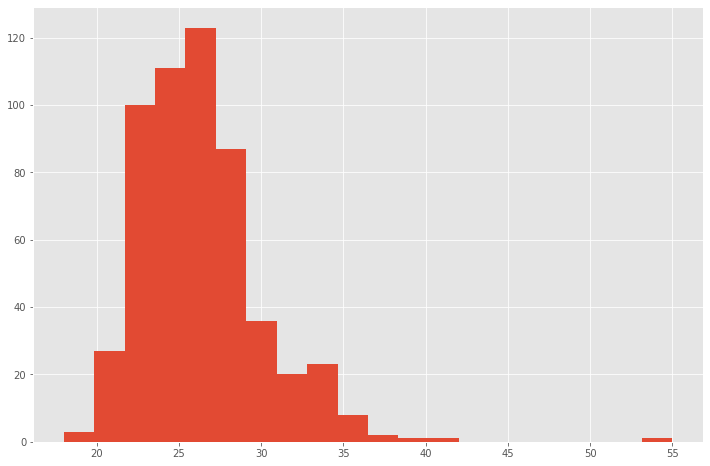

In [20]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [21]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [22]:
df = df.dropna(subset=['age'])

#### field:		
field of study  

#### field_cd: 	
field coded 


In [23]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [24]:
df.field_cd.isnull().sum()

19

In [25]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [26]:
df = df.drop(['field'], axis=1)

Надо же как-то закодировать field_cd!

In [27]:
## Your code here

#### undergrd:  	
school attended for undergraduate degree

Пока выкинем

In [28]:
df.undergra.value_counts().head()

UC Berkeley    107
Harvard        104
Columbia        95
Yale            86
NYU             78
Name: undergra, dtype: int64

In [29]:
df = df.drop(['undergra'], axis=1)

#### mn_sat: 	
Median SAT score for the undergraduate institution where attended.  			

In [30]:
df.mn_sat.value_counts().head()

1,400.00    403
1,430.00    262
1,290.00    190
1,450.00    163
1,340.00    146
Name: mn_sat, dtype: int64

In [31]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

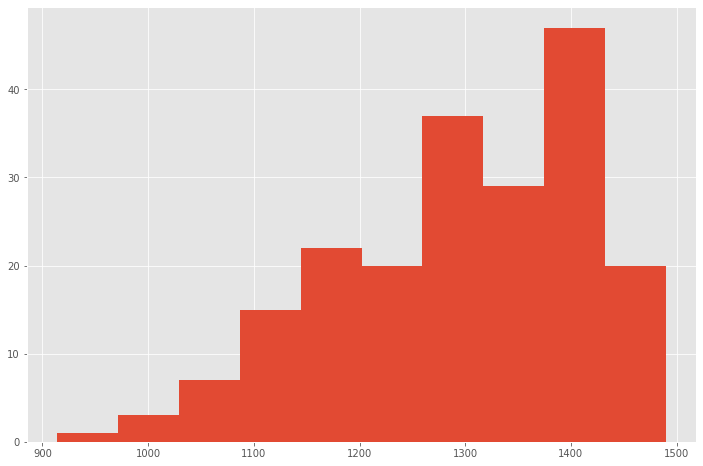

In [32]:
df.drop_duplicates('iid').mn_sat.hist()

In [33]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

In [34]:
# Что будем делать?

#
df['mn_sat'] = df['mn_sat'].fillna(0.0)

#### tuition: 	
Tuition listed for each response to undergrad in Barron’s 25th Edition college profile book.

In [35]:
df.tuition.value_counts().head()

26,908.00    241
26,019.00    174
15,162.00    138
25,380.00    112
26,062.00    108
Name: tuition, dtype: int64

In [36]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

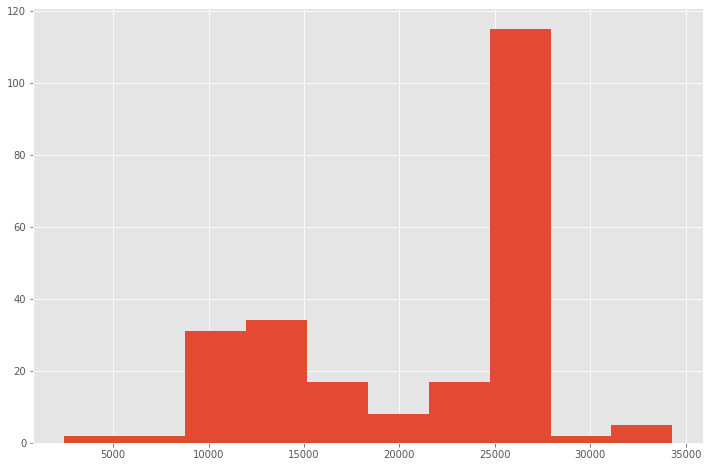

In [37]:
df.drop_duplicates('iid').tuition.hist()

In [38]:
df.drop_duplicates('iid').tuition.isnull().sum()

310

In [39]:
# Что будем делать?

# 
df['tuition'] = df['tuition'].fillna(0.0)

#### race:
* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6


In [40]:
# Ну тут вы уже сами знаете как быть


#### imprace:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

#### imprelig:
 How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?


In [41]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [42]:
df.drop_duplicates('iid').imprelig.isnull().sum()

1

In [43]:
# Что делать?

df = df.dropna(subset=['imprelig', 'imprace'])

#### from:
Where are you from originally (before coming to Columbia)? 

#### zipcode:
What was the zip code of the area where you grew up? 

Выкидываем

In [44]:
df = df.drop(['from', 'zipcode'], axis=1)

#### income

In [45]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

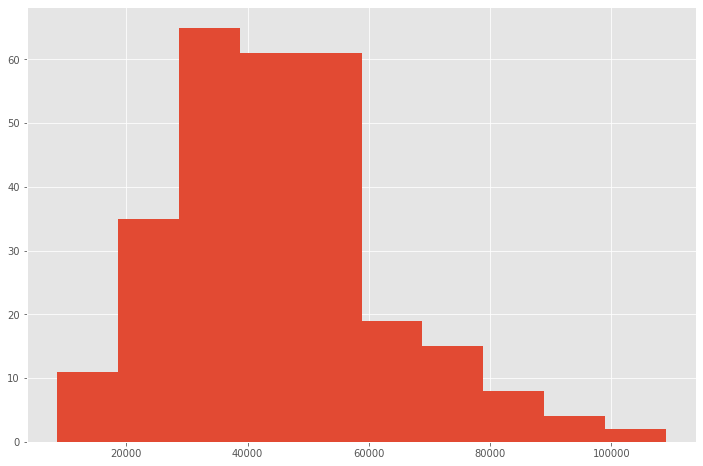

In [46]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [47]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

261

In [48]:
df = df.drop(['income'], axis=1)
# df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

#### goal:
    What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6

#### date:
    In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

#### go out:
    How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

Как бы вы предложили закодировать эти переменные?

In [49]:
df = df.dropna(subset=['date'])

#### career:
What is your intended career?

#### career_c: 
career coded 

Работаем аналогично field и field_cd

In [50]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [51]:
df.career_c.isnull().sum()

59

In [52]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [53]:
df = df.drop(['career'], axis=1)

In [54]:
# Теперь это надо закодировать


How interested are you in the following activities, on a scale of 1-10?
    
    sports: Playing sports/ athletics
    tvsports: Watching sports
    excersice: Body building/exercising
    dining: Dining out
    museums: Museums/galleries
    art: Art
    hiking:  Hiking/camping
    gaming: Gaming
    clubbing: Dancing/clubbing
    reading: Reading
    tv: Watching TV
    theater: Theater
    movies: Movies
    concerts: Going to concerts
    music: Music
    shopping: Shopping
    yoga: Yoga/meditation

По большому счету с этими признаками можно придумать много чего.. Например у нас уже есть признак, который считает корреляцию между интересами пар. Пока мы все их выкинем

In [55]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [56]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

#### exphappy:
Overall, on a scale of 1-10, how happy do you expect to be with the people you meet 
during the speed-dating event?

#### expnum: 
Out of the 20 people you will meet, how many do you expect will be interested in dating you? 


In [57]:
df.drop_duplicates('iid').exphappy.isnull().sum()

0

In [58]:
df.drop_duplicates('iid').expnum.isnull().sum()

416

In [59]:
df = df.drop(['expnum'], axis=1)

### Attr1

We want to know what you look for in the opposite sex. 
Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):
Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.

attr1_1 
Attractive

sinc1_1
Sincere

intel1_1
Intelligent

fun1_1
Fun

amb1_1
Ambitious

shar1_1
Has shared interests/hobbies


In [60]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [61]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [62]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [63]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

In [64]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
918,67,3,20.0,15.0,20.0,20.0,5.0,10.0,90.0
1530,105,4,30.0,15.0,20.0,20.0,0.0,5.0,90.0
7221,489,19,20.0,10.0,20.0,20.0,20.0,0.0,90.0
7586,517,21,15.0,20.0,20.0,20.0,5.0,10.0,90.0
7784,526,21,10.0,10.0,30.0,20.0,10.0,15.0,95.0


In [65]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [66]:
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


Ну понятно, надо чутка подредактировать исходные признаки и в бой

In [67]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [68]:
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

Проведите аналогичную работу для признаков `attr2`

### Attr2

In [69]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

In [70]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

In [71]:
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [72]:
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

In [73]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
4816,320,12,20.0,10.0,10.0,10.0,20.0,10.0,80.0


In [74]:
idx = ((temp.wave >= 6) & (temp.wave <= 9))

In [75]:
temp.loc[idx, ]

,iid,wave,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,totalsum
1846,132,6,22.73,15.91,13.64,15.91,13.64,18.18,100.01
1851,133,6,24.32,16.22,13.51,16.22,10.81,18.92,100.00
1856,134,6,20.51,15.38,12.82,20.51,12.82,17.95,99.99
1861,135,6,18.75,16.67,14.58,18.75,18.75,12.50,100.00
1871,137,6,14.89,17.02,17.02,17.02,14.89,19.15,99.99
...,...,...,...,...,...,...,...,...,...
3308,229,9,15.22,19.57,15.22,17.39,21.74,10.87,100.01
3328,230,9,16.67,16.67,16.67,16.67,16.67,16.67,100.02
3348,231,9,18.18,11.36,15.91,18.18,20.45,15.91,99.99
3368,232,9,19.15,17.02,17.02,17.02,14.89,14.89,99.99


In [76]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [77]:
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [78]:
df = df.drop(['temp_totalsum'], axis=1)

Признаки `attr4` и `attr5` пока выбросим

In [79]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [80]:
df = df.drop(['wave'], axis=1)

In [81]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

#### Задание

* Объедините два датафрейма с помощью метода `join`
* Выделите предикторы в матрицу `X` (numpy.array), а целевой признак в вектор `y`(numpy.array)
* С помощью метода `train_test_split` разбейте данные на обучаюущю и валидационную выборку

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Your Code Here

df = df_male.join(df_female)
df = df.fillna(value = 0)

X = np.array(df.drop(['match'], axis = 1))
y = np.array(df['match'])

#### Задание

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

In [ ]:
# Your Code Here

#### Задание

Обучите модель с наилучшей глубиной.

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [ ]:
# Your Code Here

#### Задание 
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок

In [ ]:
# Your Code Here

#### Задание
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Your Code Here

#### Задание
* С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Your Code Here